In [3]:
# del_sv equation test 

In [4]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import linregress

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [5]:
warnings.filterwarnings('ignore')

In [17]:
# MERRA2_dir = '/w2-data2/willytsai/MERRA2/'
# Gridsat_dir = '/w2-data/willytsai/gridsat_BT/remap_0.25deg/'
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
# MERRA2_3d_dir = '/w2-data/willytsai/TQUV_3hr/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.1deg/'
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
MERRA2_3d_dir = '/data/willytsai/TQUV_3hr/'
MERRA2_TQCI_dir = '/data/willytsai/TQCI_3hr'
AIRS_dir = '/data/willytsai/AIRS_daily'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
WHOI_dir = '/data/willytsai/WHOI_oaflux/'

In [7]:
def event_region(lat_event,lon_event,lon_w,lon_e,lat_s,lat_n):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event < lon_e))[0]
    idy = np.where(np.logical_and(lat_event >= lat_s, lat_event < lat_n))[0]
    idc = np.intersect1d(idx,idy)
    return idc

In [8]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [29]:
# load data
#os.chdir('/w2-data/willytsai/ISCCP/')
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds.dat'))

In [30]:
# precipitation events over specific basins: 
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]
idx_REG = event_region(lat_event,lon_event,-180,180,-10,10) # all tropics

# total event over IND
time_event = np.asarray(time_event); time_event = time_event[idx_REG]
lat_event = var_dataset[idx_REG,0]
lon_event = var_dataset[idx_REG,1]

In [31]:
t_org = np.where(lat_event>-50)[0]

In [32]:
len(t_org)

108419

In [34]:
os.chdir('/data/willytsai/ISCCP/')
test_data = np.load('mse_all_5deg_4ds.mat.npy')

In [35]:
test_data.shape

(108419, 33, 42)

In [16]:
MERRA2_3d_dir

'/data/willytsai/'

In [39]:
t=0

In [40]:
## function derived MERRA2

data_sub = subset_MERRA2(MERRA2_3d_dir
           ,time_event[t],lat_event[t],lon_event[t],days=2,lon_inc=2.5,lat_inc=2.5)
data_sub2 = subset_MERRA2(MERRA2_3d_dir+'../omega_3hr'
           ,time_event[t],lat_event[t],lon_event[t],days=2,
           lat_inc=2.5,lon_inc=2.5)
data_sub3 = subset_MERRA2(MERRA2_3d_dir+'../geoheight_3hr/'
           ,time_event[t],lat_event[t],lon_event[t],days=2,
           lat_inc=2.5,lon_inc=2.5)

u_sm = data_sub.U
v_sm = data_sub.V
T_sm = data_sub.T
omega_sm = data_sub2.OMEGA
q_sm = data_sub.QV
z_sm = data_sub3.H
lev = T_sm.lev
lon = T_sm.lon
lat = T_sm.lat

h_sm = 1004*T_sm + 2.5e6*q_sm + 9.8*z_sm 
s_sm = 1004*T_sm + 9.8*z_sm 

hsm = np.nanmean(h_sm,axis=(2,3))
ssm = np.nanmean(s_sm,axis=(2,3))

# GMS_test formula
dhdpm = np.gradient(h_sm,h_sm.lev*100,axis=1)
dsdpm = np.gradient(s_sm,s_sm.lev*100,axis=1)

# MERRA2 function formula
dhdx = np.nanmean(np.gradient(h_sm,lon*100000,axis=3),axis=(2,3))
dhdy = np.nanmean(np.gradient(h_sm,lat*100000,axis=2),axis=(2,3))
hadv_org = u_sm.mean(axis=(2,3))*dhdx + v_sm.mean(axis=(2,3))*dhdy

dsdx = np.nanmean(np.gradient(s_sm,lon*100000,axis=3),axis=(2,3))
dsdy = np.nanmean(np.gradient(s_sm,lat*100000,axis=2),axis=(2,3))
sadv_org = u_sm.mean(axis=(2,3))*dsdx + v_sm.mean(axis=(2,3))*dsdy

s_adv_GMS = np.nanmean(u_sm,axis=(2,3))*dsdx + np.nanmean(v_sm,axis=(2,3))*dsdy                                       
h_adv_GMS = np.nanmean(u_sm,axis=(2,3))*dhdx + np.nanmean(v_sm,axis=(2,3))*dhdy 
#wdsdp_GMS = np.nanmean(omega_sm,axis=(2,3))*np.nanmean(dsdpm,axis=(2,3))
#wdsdp_M2 = np.nanmean(omega_sm,axis=(2,3))*np.gradient(ssm,lev*100,axis=1)

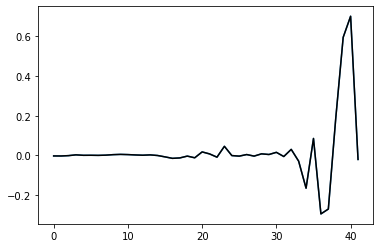

In [44]:
plt.plot(s_adv_GMS[10,:])
plt.plot(sadv_org[10,:],'k')